In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

## Read data

In [8]:
import os
SEQ_LEN = 64
IM_SIZE = 28

In [12]:
def read_img_sequences(path_to_folder, size=500):
    curr_size = 0
    data = []
    labels = []
    
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * SEQ_LEN
        sequence_labels = [None] * SEQ_LEN
        
        for img_path in os.listdir(full_sequence_folder):
            # -3: drop .pt
            im_index, label = img_path[:-3].split('_')
            im_index = int(im_index)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            # load image and reshape to vector
            img = torch.load(full_path_to_img).view(IM_SIZE * IM_SIZE).detach().cpu().numpy()
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [13]:
anomaly_data, anomaly_labels = read_img_sequences('data_4_in_7/img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('data_4_in_7/img_ts_normal/')

In [14]:
len(anomaly_data)

500

In [15]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == 7).astype(int)

In [16]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

## Loss function

In [17]:
device = torch.device('cuda')

In [18]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [19]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:0')

In [47]:
class CustomLoss(nn.Module):
    
    def __init__(self, alpha=0.5, w=16):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.w = w
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                #w = 16
                #alpha = 0.5
                loss[i] = (self.alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + self.w)], self.w) + 
                           (1 - self.alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [21]:
# input data parameters
input_size = IM_SIZE * IM_SIZE
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [22]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [23]:
device = torch.device("cuda:1")

In [24]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [25]:
def train_model(model, loss_function, epochs=100, print_every=5, LSTM_flag = True):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

## LSTM Model

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        #hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        
        return hidden

In [27]:
model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_LSTM_custom.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [28]:
model_LSTM_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 5, LSTM_flag=True)

Epoch: 1/60... Step: 5... Loss: -2.069258... Val Loss: -1.867634
Epoch: 2/60... Step: 10... Loss: -2.323091... Val Loss: -2.273195
Epoch: 2/60... Step: 15... Loss: -2.882021... Val Loss: -3.297965
Epoch: 3/60... Step: 20... Loss: -3.245341... Val Loss: -4.917231
Epoch: 3/60... Step: 25... Loss: -9.507681... Val Loss: -5.895977
Epoch: 4/60... Step: 30... Loss: -7.999971... Val Loss: -8.782153
Epoch: 4/60... Step: 35... Loss: -9.238044... Val Loss: -9.184352
Epoch: 5/60... Step: 40... Loss: -10.772788... Val Loss: -8.122883
Epoch: 5/60... Step: 45... Loss: -10.686874... Val Loss: -11.362809
Epoch: 6/60... Step: 50... Loss: -9.826374... Val Loss: -10.002202
Epoch: 7/60... Step: 55... Loss: -10.634255... Val Loss: -10.354549
Epoch: 7/60... Step: 60... Loss: -10.408157... Val Loss: -10.997051
Epoch: 8/60... Step: 65... Loss: -13.220749... Val Loss: -10.588758
Epoch: 8/60... Step: 70... Loss: -12.929533... Val Loss: -11.007440
Epoch: 9/60... Step: 75... Loss: -12.027537... Val Loss: -11.8209

In [29]:
model_LSTM_bce = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_LSTM_bce.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [30]:
model_LSTM_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_LSTM_bce, bce_loss_function, 
                                                                                       60, 5, LSTM_flag=True)

Epoch: 1/60... Step: 5... Loss: 0.601782... Val Loss: 0.590719
Epoch: 2/60... Step: 10... Loss: 0.445008... Val Loss: 0.404826
Epoch: 2/60... Step: 15... Loss: 0.316202... Val Loss: 0.311624
Epoch: 3/60... Step: 20... Loss: 0.215332... Val Loss: 0.248975
Epoch: 3/60... Step: 25... Loss: 0.190846... Val Loss: 0.179747
Epoch: 4/60... Step: 30... Loss: 0.122620... Val Loss: 0.123877
Epoch: 4/60... Step: 35... Loss: 0.086201... Val Loss: 0.082894
Epoch: 5/60... Step: 40... Loss: 0.049946... Val Loss: 0.062588
Epoch: 5/60... Step: 45... Loss: 0.047334... Val Loss: 0.056278
Epoch: 6/60... Step: 50... Loss: 0.051752... Val Loss: 0.068186
Epoch: 7/60... Step: 55... Loss: 0.034629... Val Loss: 0.058111
Epoch: 7/60... Step: 60... Loss: 0.043350... Val Loss: 0.063119
Epoch: 8/60... Step: 65... Loss: 0.037182... Val Loss: 0.055171
Epoch: 8/60... Step: 70... Loss: 0.042268... Val Loss: 0.050838
Epoch: 9/60... Step: 75... Loss: 0.030361... Val Loss: 0.049891
Epoch: 9/60... Step: 80... Loss: 0.026534

In [31]:
model_LSTM_combined = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_LSTM_combined.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [32]:
model_LSTM_combined, _ = train_model(model_LSTM_combined, second_custom_loss_function, 30, 5, 
                                    LSTM_flag=True)

Epoch: 1/30... Step: 5... Loss: -1.284327... Val Loss: -1.809622
Epoch: 2/30... Step: 10... Loss: -3.000785... Val Loss: -2.507218
Epoch: 2/30... Step: 15... Loss: -3.765089... Val Loss: -3.212840
Epoch: 3/30... Step: 20... Loss: -4.213460... Val Loss: -4.073086
Epoch: 3/30... Step: 25... Loss: -7.105561... Val Loss: -6.260559
Epoch: 4/30... Step: 30... Loss: -6.263509... Val Loss: -7.214925
Epoch: 4/30... Step: 35... Loss: -6.752656... Val Loss: -7.191236
Epoch: 5/30... Step: 40... Loss: -7.594733... Val Loss: -8.326560
Epoch: 5/30... Step: 45... Loss: -10.770649... Val Loss: -9.876364
Epoch: 6/30... Step: 50... Loss: -9.489916... Val Loss: -10.086832
Epoch: 7/30... Step: 55... Loss: -12.522557... Val Loss: -10.680277
Epoch: 7/30... Step: 60... Loss: -9.725799... Val Loss: -11.360797
Epoch: 8/30... Step: 65... Loss: -8.592749... Val Loss: -11.659732
Epoch: 8/30... Step: 70... Loss: -12.458275... Val Loss: -9.594180
Epoch: 9/30... Step: 75... Loss: -11.843534... Val Loss: -11.935314
Ep

In [33]:
model_LSTM_combined, __ = train_model(model_LSTM_combined, first_bce_loss_function, 30, 5, 
                                      LSTM_flag=True)

Epoch: 1/30... Step: 5... Loss: 0.085803... Val Loss: 0.084739
Epoch: 2/30... Step: 10... Loss: 0.037191... Val Loss: 0.056478
Epoch: 2/30... Step: 15... Loss: 0.048014... Val Loss: 0.054692
Epoch: 3/30... Step: 20... Loss: 0.052914... Val Loss: 0.039679
Epoch: 3/30... Step: 25... Loss: 0.035196... Val Loss: 0.040596
Epoch: 4/30... Step: 30... Loss: 0.030560... Val Loss: 0.042491
Epoch: 4/30... Step: 35... Loss: 0.036317... Val Loss: 0.039320
Epoch: 5/30... Step: 40... Loss: 0.034559... Val Loss: 0.033430
Epoch: 5/30... Step: 45... Loss: 0.029170... Val Loss: 0.039419
Epoch: 6/30... Step: 50... Loss: 0.023669... Val Loss: 0.035006
Epoch: 7/30... Step: 55... Loss: 0.026603... Val Loss: 0.037090
Epoch: 7/30... Step: 60... Loss: 0.023008... Val Loss: 0.038837
Epoch: 8/30... Step: 65... Loss: 0.030911... Val Loss: 0.044746
Epoch: 8/30... Step: 70... Loss: 0.016548... Val Loss: 0.047217
Epoch: 9/30... Step: 75... Loss: 0.018037... Val Loss: 0.042116
Epoch: 9/30... Step: 80... Loss: 0.016152

In [34]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [35]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=True):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:

        if test_inputs.shape[0] < test_batch_size:
            break
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)

        if LSTM_flag:
            test_hidden = model.init_hidden(batch_size)
            #test_hidden = tuple([each.data for each in test_hidden])
            test_predictions, test_hidden = model(test_inputs, test_hidden)
        else:
            test_predictions = model(test_inputs)
            
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [36]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list, LSTM_flag=True):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold, LSTM_flag)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        #print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

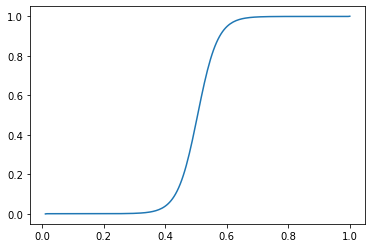

In [37]:
threshold_number = 200
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]
plt.plot(np.linspace(0.01, 1, threshold_number + 2), threshold_list)

In [38]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_bce, fn_number_list_LSTM_bce, 
 delay_list_LSTM_bce, fp_delay_list_LSTM_bce) = get_pareto_metrics_for_threshold(model_LSTM_bce, final_test_loader, 
                                                                                 threshold_list, LSTM_flag=True)

In [39]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
 delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                       threshold_list, LSTM_flag=True)

In [40]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_combined, fn_number_list_LSTM_combined, delay_list_LSTM_combined, fp_delay_list_LSTM_combined) = get_pareto_metrics_for_threshold(model_LSTM_combined, final_test_loader, threshold_list, LSTM_flag=True)

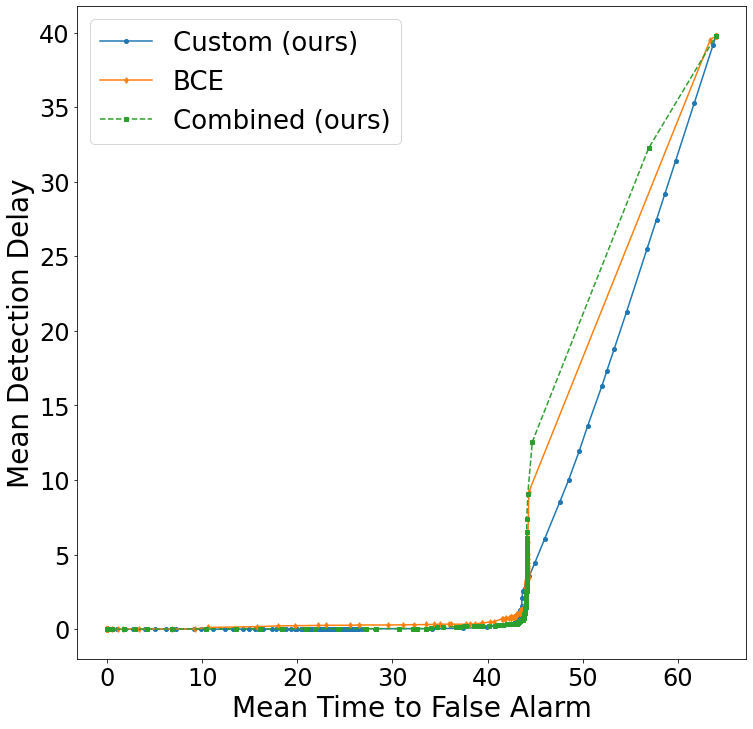

In [42]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('mnist_4_in_7_curve.pdf', bbox_inches='tight')

In [ ]:
def save_metrics_to_file_new_version(model_name, model, test_loader, batch_size,
                                     seq_len, fp_delay, threshold_list, x_coord_arr, path_to_save = ""):
  columns_list = ["Model name", "Mean FP delay", "Mean delay", "Threshold", "TP", "TN", "FP", "FN", "Acc",
                "Precision", "Recall", "F1-score", "G-mean"]
  data_model_results = metrics_by_fp_delay_x_coord(model_name, model, test_loader, batch_size, seq_len,
                                                   fp_delay, threshold_list, x_coord_arr)
  df_main = pd.DataFrame(data_model_results, columns = columns_list)
  df_main.to_excel(os.path.join(path_to_save, model_name + ".xlsx" ), index = False)

In [44]:
%load_ext autoreload
%autoreload 1
%aimport metrics


In [52]:
model_LSTM_custom.to('cuda:0')

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [54]:
metrics.save_metrics_to_file_new_version('Custom', model_LSTM_custom, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_custom, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 39.99, 45, 50], path_to_save = "")

33.984375 0.33662029495232143 35.078125 0.3710679107501842 35
TP: 12 TN: 29 FP: 23 FN: 0 DELAY: 0.125 FP_DELAY 43.671875
39.5625 0.9564971876670771 43.546875 0.9623558248267451 39.99
TP: 14 TN: 38 FP: 6 FN: 6 DELAY: 5.21875 FP_DELAY 50.515625
43.546875 0.9623558248267451 48.21875 0.9674523120684658 45
TP: 7 TN: 36 FP: 2 FN: 19 DELAY: 10.328125 FP_DELAY 57.28125
48.21875 0.9674523120684658 53.96875 0.9718789695244026 50
TP: 6 TN: 38 FP: 1 FN: 19 DELAY: 10.0625 FP_DELAY 58.578125


In [45]:
metrics.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom)

413.57017686631946

In [64]:
model_LSTM_bce.to('cuda:0')

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [65]:
metrics.save_metrics_to_file_new_version('BCE', model_LSTM_bce, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_bce, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 39.9, 45, 50], path_to_save = "")

34.328125 0.02812103047559733 35.375 0.03254768793153412 35
TP: 12 TN: 35 FP: 17 FN: 0 DELAY: 0.265625 FP_DELAY 43.5
38.421875 0.9999401505276208 57.96875 0.9999485254648226 39.9
TP: 27 TN: 35 FP: 1 FN: 1 DELAY: 5.890625 FP_DELAY 47.953125
38.421875 0.9999401505276208 57.96875 0.9999485254648226 45
TP: 22 TN: 34 FP: 1 FN: 7 DELAY: 9.84375 FP_DELAY 50.796875
38.421875 0.9999401505276208 57.96875 0.9999485254648226 50
TP: 16 TN: 33 FP: 1 FN: 14 DELAY: 13.75 FP_DELAY 55.203125


In [66]:
metrics.area_under_graph(delay_list_LSTM_bce, fp_delay_list_LSTM_bce)

788.3809070121953

In [68]:
metrics.save_metrics_to_file_new_version('Cobined', model_LSTM_combined, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_combined, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 40, 45, 50], path_to_save = "")

34.984375 0.01807518260025041 35.125 0.020954573680812282 35
TP: 8 TN: 35 FP: 21 FN: 0 DELAY: 0.03125 FP_DELAY 46.4375
38.71875 0.9998521398034467 58.515625 0.9998728288098837 40
TP: 26 TN: 37 FP: 0 FN: 1 DELAY: 6.375 FP_DELAY 47.84375
38.71875 0.9998521398034467 58.515625 0.9998728288098837 45
TP: 19 TN: 34 FP: 0 FN: 11 DELAY: 11.359375 FP_DELAY 52.953125
38.71875 0.9998521398034467 58.515625 0.9998728288098837 50
TP: 9 TN: 40 FP: 0 FN: 15 DELAY: 12.015625 FP_DELAY 58.875


In [69]:
metrics.area_under_graph(delay_list_LSTM_combined, fp_delay_list_LSTM_combined)

786.539824695122

In [60]:
model_LSTM_combined.to('cuda:0')

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [62]:
metrics.save_metrics_to_file_new_version('Combined', model_LSTM_bce, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_custom, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 39.99, 45, 50], path_to_save = "")

33.984375 0.33662029495232143 35.078125 0.3710679107501842 35
TP: 18 TN: 36 FP: 10 FN: 0 DELAY: 0.4375 FP_DELAY 46.375
39.5625 0.9564971876670771 43.546875 0.9623558248267451 39.99
TP: 22 TN: 33 FP: 9 FN: 0 DELAY: 0.609375 FP_DELAY 44.703125
43.546875 0.9623558248267451 48.21875 0.9674523120684658 45
TP: 20 TN: 36 FP: 8 FN: 0 DELAY: 0.59375 FP_DELAY 47.453125
48.21875 0.9674523120684658 53.96875 0.9718789695244026 50
TP: 17 TN: 39 FP: 8 FN: 0 DELAY: 0.28125 FP_DELAY 48.609375


# ALPHAS

In [48]:
from tqdm import tqdm

res_metrics = []
res_auc = []
for i in range(10):

    alphas = np.linspace(0, 1, 11)
    alpha_dict_metrics = {}
    alpha_dict_auc = {}


    for alpha in tqdm(alphas):

        model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
        loss_function = CustomLoss(alpha=alpha)
        model_LSTM_custom.to(device)

        model_LSTM_custom, (loss_list, acc_list, 
                            overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 100, LSTM_flag=True)


        test_batch_size = 64
        final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

        (fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
         delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                               threshold_list, LSTM_flag=True)

        alpha_dict_metrics[alpha] = (fp_delay_list_LSTM_custom, delay_list_LSTM_custom)

        alpha_dict_auc[alpha] = metrics.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom)
    res_metrics.append(alpha_dict_metrics)
    res_auc.append(alpha_dict_auc)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -12.515485... Val Loss: -12.997308
Epoch: 23/60... Step: 200... Loss: -14.780812... Val Loss: -13.099397
Epoch: 34/60... Step: 300... Loss: -14.811588... Val Loss: -12.822752
Epoch: 45/60... Step: 400... Loss: -15.075364... Val Loss: -16.179716
Epoch: 56/60... Step: 500... Loss: -14.259681... Val Loss: -15.134469


  9%|▉         | 1/11 [03:13<32:10, 193.04s/it]

Epoch: 12/60... Step: 100... Loss: -12.025648... Val Loss: -12.016809
Epoch: 23/60... Step: 200... Loss: -14.971754... Val Loss: -11.873099
Epoch: 34/60... Step: 300... Loss: -14.843706... Val Loss: -16.000578
Epoch: 45/60... Step: 400... Loss: -14.766596... Val Loss: -14.862437
Epoch: 56/60... Step: 500... Loss: -14.867004... Val Loss: -15.842430


 18%|█▊        | 2/11 [06:26<28:58, 193.15s/it]

Epoch: 12/60... Step: 100... Loss: -13.804756... Val Loss: -13.209765
Epoch: 23/60... Step: 200... Loss: -15.674810... Val Loss: -13.887077
Epoch: 34/60... Step: 300... Loss: -17.091822... Val Loss: -16.622108
Epoch: 45/60... Step: 400... Loss: -16.525263... Val Loss: -13.638174
Epoch: 56/60... Step: 500... Loss: -15.570006... Val Loss: -14.377988


 27%|██▋       | 3/11 [09:40<25:48, 193.51s/it]

Epoch: 12/60... Step: 100... Loss: -11.106417... Val Loss: -12.532331
Epoch: 23/60... Step: 200... Loss: -12.343450... Val Loss: -13.510683
Epoch: 34/60... Step: 300... Loss: -14.619591... Val Loss: -13.711432
Epoch: 45/60... Step: 400... Loss: -15.936661... Val Loss: -14.772069
Epoch: 56/60... Step: 500... Loss: -18.471916... Val Loss: -14.234256


 36%|███▋      | 4/11 [12:54<22:34, 193.56s/it]

Epoch: 12/60... Step: 100... Loss: -16.305197... Val Loss: -13.514222
Epoch: 23/60... Step: 200... Loss: -14.200921... Val Loss: -11.667102
Epoch: 34/60... Step: 300... Loss: -10.168845... Val Loss: -14.281420
Epoch: 45/60... Step: 400... Loss: -15.025995... Val Loss: -14.743072
Epoch: 56/60... Step: 500... Loss: -13.544096... Val Loss: -13.969720


 45%|████▌     | 5/11 [16:07<19:19, 193.25s/it]

Epoch: 12/60... Step: 100... Loss: -10.855137... Val Loss: -11.969090
Epoch: 23/60... Step: 200... Loss: -13.308493... Val Loss: -12.751258
Epoch: 34/60... Step: 300... Loss: -14.066183... Val Loss: -13.160411
Epoch: 45/60... Step: 400... Loss: -13.719516... Val Loss: -13.308034
Epoch: 56/60... Step: 500... Loss: -16.082727... Val Loss: -13.106266


 55%|█████▍    | 6/11 [19:18<16:04, 192.83s/it]

Epoch: 12/60... Step: 100... Loss: -13.004402... Val Loss: -11.741370
Epoch: 23/60... Step: 200... Loss: -12.732981... Val Loss: -10.796782
Epoch: 34/60... Step: 300... Loss: -13.211102... Val Loss: -12.826456
Epoch: 45/60... Step: 400... Loss: -14.126420... Val Loss: -12.058727
Epoch: 56/60... Step: 500... Loss: -14.994920... Val Loss: -11.748574


 64%|██████▎   | 7/11 [22:30<12:49, 192.50s/it]

Epoch: 12/60... Step: 100... Loss: -12.603778... Val Loss: -10.586052
Epoch: 23/60... Step: 200... Loss: -12.789440... Val Loss: -12.423771
Epoch: 34/60... Step: 300... Loss: -14.044136... Val Loss: -12.440180
Epoch: 45/60... Step: 400... Loss: -16.250589... Val Loss: -13.094162
Epoch: 56/60... Step: 500... Loss: -13.490755... Val Loss: -12.609126


 73%|███████▎  | 8/11 [25:41<09:36, 192.09s/it]

Epoch: 12/60... Step: 100... Loss: -10.445654... Val Loss: -7.153103
Epoch: 23/60... Step: 200... Loss: -12.219868... Val Loss: -11.057698
Epoch: 34/60... Step: 300... Loss: -16.530449... Val Loss: -11.115745
Epoch: 45/60... Step: 400... Loss: -11.366751... Val Loss: -11.047874
Epoch: 56/60... Step: 500... Loss: -15.774507... Val Loss: -11.511434


 82%|████████▏ | 9/11 [28:54<06:24, 192.18s/it]

Epoch: 12/60... Step: 100... Loss: -12.889327... Val Loss: -9.115185
Epoch: 23/60... Step: 200... Loss: -15.389780... Val Loss: -10.477975
Epoch: 34/60... Step: 300... Loss: -11.931273... Val Loss: -9.623828
Epoch: 45/60... Step: 400... Loss: -11.616815... Val Loss: -12.561365
Epoch: 56/60... Step: 500... Loss: -10.923502... Val Loss: -11.219631


 91%|█████████ | 10/11 [32:07<03:12, 192.51s/it]

Epoch: 12/60... Step: 100... Loss: -12.459049... Val Loss: -10.166579
Epoch: 23/60... Step: 200... Loss: -12.970298... Val Loss: -9.970801
Epoch: 34/60... Step: 300... Loss: -11.778871... Val Loss: -10.477231
Epoch: 45/60... Step: 400... Loss: -11.253984... Val Loss: -10.726561
Epoch: 56/60... Step: 500... Loss: -6.497364... Val Loss: -10.914300


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -12.383971... Val Loss: -12.277482
Epoch: 23/60... Step: 200... Loss: -13.453294... Val Loss: -13.195935
Epoch: 34/60... Step: 300... Loss: -14.170652... Val Loss: -14.321043
Epoch: 45/60... Step: 400... Loss: -15.255019... Val Loss: -15.094597
Epoch: 56/60... Step: 500... Loss: -14.453508... Val Loss: -14.206662


  9%|▉         | 1/11 [03:11<31:50, 191.10s/it]

Epoch: 12/60... Step: 100... Loss: -13.433928... Val Loss: -13.558966
Epoch: 23/60... Step: 200... Loss: -15.230358... Val Loss: -14.855584
Epoch: 34/60... Step: 300... Loss: -14.334776... Val Loss: -15.097487
Epoch: 45/60... Step: 400... Loss: -17.111284... Val Loss: -15.997109
Epoch: 56/60... Step: 500... Loss: -13.499631... Val Loss: -13.676798


 18%|█▊        | 2/11 [06:23<28:44, 191.59s/it]

Epoch: 12/60... Step: 100... Loss: -14.239401... Val Loss: -12.625706
Epoch: 23/60... Step: 200... Loss: -14.536383... Val Loss: -14.064129
Epoch: 34/60... Step: 300... Loss: -14.690253... Val Loss: -14.604707
Epoch: 45/60... Step: 400... Loss: -15.829489... Val Loss: -15.642856
Epoch: 56/60... Step: 500... Loss: -16.183405... Val Loss: -16.370817


 27%|██▋       | 3/11 [09:36<25:34, 191.79s/it]

Epoch: 12/60... Step: 100... Loss: -12.340738... Val Loss: -11.891952
Epoch: 23/60... Step: 200... Loss: -13.250834... Val Loss: -14.397146
Epoch: 34/60... Step: 300... Loss: -15.493008... Val Loss: -13.777374
Epoch: 45/60... Step: 400... Loss: -15.543824... Val Loss: -14.542043
Epoch: 56/60... Step: 500... Loss: -15.730880... Val Loss: -15.216832


 36%|███▋      | 4/11 [12:48<22:23, 192.00s/it]

Epoch: 12/60... Step: 100... Loss: -9.217350... Val Loss: -12.604972
Epoch: 23/60... Step: 200... Loss: -13.902456... Val Loss: -13.847150
Epoch: 34/60... Step: 300... Loss: -17.922354... Val Loss: -13.944092
Epoch: 45/60... Step: 400... Loss: -13.441336... Val Loss: -14.614578
Epoch: 56/60... Step: 500... Loss: -14.182827... Val Loss: -14.589986


 45%|████▌     | 5/11 [16:01<19:12, 192.13s/it]

Epoch: 12/60... Step: 100... Loss: -11.842842... Val Loss: -12.528244
Epoch: 23/60... Step: 200... Loss: -15.144783... Val Loss: -11.684607
Epoch: 34/60... Step: 300... Loss: -11.737965... Val Loss: -13.368567
Epoch: 45/60... Step: 400... Loss: -14.563523... Val Loss: -13.335881
Epoch: 56/60... Step: 500... Loss: -14.828104... Val Loss: -12.018309


 55%|█████▍    | 6/11 [19:56<17:05, 205.11s/it]

Epoch: 12/60... Step: 100... Loss: -13.148733... Val Loss: -11.924122
Epoch: 23/60... Step: 200... Loss: -15.234392... Val Loss: -11.579815
Epoch: 34/60... Step: 300... Loss: -13.235935... Val Loss: -12.680215
Epoch: 45/60... Step: 400... Loss: -12.701380... Val Loss: -12.359090
Epoch: 56/60... Step: 500... Loss: -13.969691... Val Loss: -11.934264


 64%|██████▎   | 7/11 [24:02<14:29, 217.45s/it]

Epoch: 12/60... Step: 100... Loss: -11.222840... Val Loss: -9.599305
Epoch: 23/60... Step: 200... Loss: -11.751734... Val Loss: -11.774593
Epoch: 34/60... Step: 300... Loss: -12.486073... Val Loss: -11.852078
Epoch: 45/60... Step: 400... Loss: -11.862374... Val Loss: -12.382849
Epoch: 56/60... Step: 500... Loss: -10.347549... Val Loss: -11.629031


 73%|███████▎  | 8/11 [28:03<11:13, 224.55s/it]

Epoch: 12/60... Step: 100... Loss: -11.688182... Val Loss: -10.365847
Epoch: 23/60... Step: 200... Loss: -14.167583... Val Loss: -11.776267
Epoch: 34/60... Step: 300... Loss: -10.353252... Val Loss: -11.807784
Epoch: 45/60... Step: 400... Loss: -11.883440... Val Loss: -11.922846
Epoch: 56/60... Step: 500... Loss: -14.384686... Val Loss: -11.921338


 82%|████████▏ | 9/11 [31:51<07:31, 225.62s/it]

Epoch: 12/60... Step: 100... Loss: -10.455854... Val Loss: -8.680060
Epoch: 23/60... Step: 200... Loss: -11.889393... Val Loss: -10.754648
Epoch: 34/60... Step: 300... Loss: -11.886791... Val Loss: -11.617031
Epoch: 45/60... Step: 400... Loss: -11.502609... Val Loss: -10.610601
Epoch: 56/60... Step: 500... Loss: -10.423967... Val Loss: -11.438252


 91%|█████████ | 10/11 [35:54<03:50, 230.65s/it]

Epoch: 12/60... Step: 100... Loss: -8.378574... Val Loss: -9.512221
Epoch: 23/60... Step: 200... Loss: -11.077587... Val Loss: -9.676030
Epoch: 34/60... Step: 300... Loss: -10.752504... Val Loss: -10.348402
Epoch: 45/60... Step: 400... Loss: -10.978870... Val Loss: -11.543371
Epoch: 56/60... Step: 500... Loss: -11.592431... Val Loss: -11.025677


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -15.340557... Val Loss: -12.876657
Epoch: 23/60... Step: 200... Loss: -10.858322... Val Loss: -13.523173
Epoch: 34/60... Step: 300... Loss: -15.959068... Val Loss: -13.594325
Epoch: 45/60... Step: 400... Loss: -13.254314... Val Loss: -15.012388
Epoch: 56/60... Step: 500... Loss: -13.620912... Val Loss: -15.320134


  9%|▉         | 1/11 [04:06<41:09, 246.96s/it]

Epoch: 12/60... Step: 100... Loss: -11.730482... Val Loss: -13.095214
Epoch: 23/60... Step: 200... Loss: -13.879748... Val Loss: -13.638788
Epoch: 34/60... Step: 300... Loss: -15.424728... Val Loss: -12.761814
Epoch: 45/60... Step: 400... Loss: -15.298613... Val Loss: -15.267758
Epoch: 56/60... Step: 500... Loss: -17.348475... Val Loss: -15.541613


 18%|█▊        | 2/11 [08:12<36:59, 246.60s/it]

Epoch: 12/60... Step: 100... Loss: -14.263795... Val Loss: -12.991324
Epoch: 23/60... Step: 200... Loss: -14.234291... Val Loss: -14.249996
Epoch: 34/60... Step: 300... Loss: -13.202428... Val Loss: -11.458960
Epoch: 45/60... Step: 400... Loss: -17.538837... Val Loss: -15.612505
Epoch: 56/60... Step: 500... Loss: -17.911461... Val Loss: -15.270479


 27%|██▋       | 3/11 [12:18<32:50, 246.30s/it]

Epoch: 12/60... Step: 100... Loss: -16.892040... Val Loss: -13.014236
Epoch: 23/60... Step: 200... Loss: -19.743151... Val Loss: -14.024607
Epoch: 34/60... Step: 300... Loss: -17.484697... Val Loss: -14.389180
Epoch: 45/60... Step: 400... Loss: -15.551834... Val Loss: -13.279210
Epoch: 56/60... Step: 500... Loss: -16.959826... Val Loss: -15.664346


 36%|███▋      | 4/11 [16:23<28:41, 246.00s/it]

Epoch: 12/60... Step: 100... Loss: -15.116899... Val Loss: -11.520153
Epoch: 23/60... Step: 200... Loss: -15.059492... Val Loss: -12.673689
Epoch: 34/60... Step: 300... Loss: -14.317507... Val Loss: -13.969308
Epoch: 45/60... Step: 400... Loss: -12.272067... Val Loss: -12.126743
Epoch: 56/60... Step: 500... Loss: -13.963328... Val Loss: -13.922343


 45%|████▌     | 5/11 [20:27<24:32, 245.44s/it]

Epoch: 12/60... Step: 100... Loss: -13.739641... Val Loss: -10.993139
Epoch: 23/60... Step: 200... Loss: -11.562807... Val Loss: -12.678473
Epoch: 34/60... Step: 300... Loss: -12.450171... Val Loss: -11.846538
Epoch: 45/60... Step: 400... Loss: -11.950959... Val Loss: -13.497214
Epoch: 56/60... Step: 500... Loss: -15.560636... Val Loss: -13.316615


 55%|█████▍    | 6/11 [24:33<20:27, 245.55s/it]

Epoch: 12/60... Step: 100... Loss: -11.614801... Val Loss: -9.290350
Epoch: 23/60... Step: 200... Loss: -17.577465... Val Loss: -12.842989
Epoch: 34/60... Step: 300... Loss: -13.997203... Val Loss: -12.615338
Epoch: 45/60... Step: 400... Loss: -14.929721... Val Loss: -13.190938
Epoch: 56/60... Step: 500... Loss: -13.361392... Val Loss: -11.774149


 64%|██████▎   | 7/11 [28:39<16:22, 245.55s/it]

Epoch: 12/60... Step: 100... Loss: -12.014755... Val Loss: -10.592911
Epoch: 23/60... Step: 200... Loss: -12.212315... Val Loss: -9.755217
Epoch: 34/60... Step: 300... Loss: -14.490190... Val Loss: -12.170621
Epoch: 45/60... Step: 400... Loss: -14.901448... Val Loss: -12.394015
Epoch: 56/60... Step: 500... Loss: -11.594077... Val Loss: -12.885348


 73%|███████▎  | 8/11 [32:43<12:15, 245.06s/it]

Epoch: 12/60... Step: 100... Loss: -10.679964... Val Loss: -9.711885
Epoch: 23/60... Step: 200... Loss: -10.956961... Val Loss: -10.044792
Epoch: 34/60... Step: 300... Loss: -11.050388... Val Loss: -11.411974
Epoch: 45/60... Step: 400... Loss: -13.950258... Val Loss: -12.396697
Epoch: 56/60... Step: 500... Loss: -12.642188... Val Loss: -11.327278


 82%|████████▏ | 9/11 [36:48<08:10, 245.30s/it]

Epoch: 12/60... Step: 100... Loss: -11.942635... Val Loss: -10.015637
Epoch: 23/60... Step: 200... Loss: -12.961702... Val Loss: -10.851937
Epoch: 34/60... Step: 300... Loss: -13.878139... Val Loss: -10.692442
Epoch: 45/60... Step: 400... Loss: -13.775581... Val Loss: -11.452690
Epoch: 56/60... Step: 500... Loss: -10.579987... Val Loss: -8.001181


 91%|█████████ | 10/11 [40:52<04:04, 244.78s/it]

Epoch: 12/60... Step: 100... Loss: -13.337905... Val Loss: -9.373702
Epoch: 23/60... Step: 200... Loss: -12.635790... Val Loss: -9.416393
Epoch: 34/60... Step: 300... Loss: -11.498116... Val Loss: -9.593588
Epoch: 45/60... Step: 400... Loss: -13.997731... Val Loss: -11.312980
Epoch: 56/60... Step: 500... Loss: -9.705257... Val Loss: -11.343003


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -12.696258... Val Loss: -12.377618
Epoch: 23/60... Step: 200... Loss: -9.644608... Val Loss: -12.047082
Epoch: 34/60... Step: 300... Loss: -13.613885... Val Loss: -12.322832
Epoch: 45/60... Step: 400... Loss: -16.555710... Val Loss: -12.477317
Epoch: 56/60... Step: 500... Loss: -13.412455... Val Loss: -14.783875


  9%|▉         | 1/11 [04:06<41:03, 246.34s/it]

Epoch: 12/60... Step: 100... Loss: -12.438747... Val Loss: -14.739540
Epoch: 23/60... Step: 200... Loss: -17.568062... Val Loss: -15.611980
Epoch: 34/60... Step: 300... Loss: -17.773170... Val Loss: -15.168219
Epoch: 45/60... Step: 400... Loss: -18.984600... Val Loss: -12.917738
Epoch: 56/60... Step: 500... Loss: -13.908678... Val Loss: -15.519571


 18%|█▊        | 2/11 [08:12<36:55, 246.18s/it]

Epoch: 12/60... Step: 100... Loss: -15.117927... Val Loss: -12.167707
Epoch: 23/60... Step: 200... Loss: -12.539269... Val Loss: -14.181648
Epoch: 34/60... Step: 300... Loss: -15.855899... Val Loss: -14.307419
Epoch: 45/60... Step: 400... Loss: -14.483842... Val Loss: -13.943461
Epoch: 56/60... Step: 500... Loss: -13.853516... Val Loss: -15.257529


 27%|██▋       | 3/11 [12:15<32:43, 245.46s/it]

Epoch: 12/60... Step: 100... Loss: -13.262418... Val Loss: -12.994252
Epoch: 23/60... Step: 200... Loss: -15.215513... Val Loss: -12.665613
Epoch: 34/60... Step: 300... Loss: -14.761106... Val Loss: -14.989464
Epoch: 45/60... Step: 400... Loss: -20.586557... Val Loss: -12.721519
Epoch: 56/60... Step: 500... Loss: -13.752033... Val Loss: -14.366152


 36%|███▋      | 4/11 [16:20<28:36, 245.14s/it]

Epoch: 12/60... Step: 100... Loss: -13.031065... Val Loss: -12.872567
Epoch: 23/60... Step: 200... Loss: -12.078844... Val Loss: -9.077578
Epoch: 34/60... Step: 300... Loss: -18.336082... Val Loss: -12.972299
Epoch: 45/60... Step: 400... Loss: -15.159851... Val Loss: -12.837104
Epoch: 56/60... Step: 500... Loss: -16.053568... Val Loss: -12.789535


 45%|████▌     | 5/11 [20:25<24:30, 245.11s/it]

Epoch: 12/60... Step: 100... Loss: -12.170009... Val Loss: -10.859687
Epoch: 23/60... Step: 200... Loss: -14.284525... Val Loss: -12.599556
Epoch: 34/60... Step: 300... Loss: -13.156485... Val Loss: -12.254043
Epoch: 45/60... Step: 400... Loss: -15.250193... Val Loss: -11.519070
Epoch: 56/60... Step: 500... Loss: -14.689209... Val Loss: -13.516880


 55%|█████▍    | 6/11 [24:32<20:28, 245.72s/it]

Epoch: 12/60... Step: 100... Loss: -10.436392... Val Loss: -11.135493
Epoch: 23/60... Step: 200... Loss: -14.754700... Val Loss: -12.351664
Epoch: 34/60... Step: 300... Loss: -12.946502... Val Loss: -13.998493
Epoch: 45/60... Step: 400... Loss: -18.232336... Val Loss: -12.472058
Epoch: 56/60... Step: 500... Loss: -13.350502... Val Loss: -12.294952


 64%|██████▎   | 7/11 [28:36<16:21, 245.35s/it]

Epoch: 12/60... Step: 100... Loss: -9.154499... Val Loss: -10.935462
Epoch: 23/60... Step: 200... Loss: -15.965389... Val Loss: -11.244262
Epoch: 34/60... Step: 300... Loss: -12.872293... Val Loss: -11.780566
Epoch: 45/60... Step: 400... Loss: -16.481264... Val Loss: -12.194322
Epoch: 56/60... Step: 500... Loss: -15.660135... Val Loss: -12.155485


 73%|███████▎  | 8/11 [32:42<12:16, 245.37s/it]

Epoch: 12/60... Step: 100... Loss: -9.390823... Val Loss: -10.730763
Epoch: 23/60... Step: 200... Loss: -11.475460... Val Loss: -11.463870
Epoch: 34/60... Step: 300... Loss: -9.710043... Val Loss: -11.341915
Epoch: 45/60... Step: 400... Loss: -16.816364... Val Loss: -11.639812
Epoch: 56/60... Step: 500... Loss: -12.345372... Val Loss: -10.982907


 82%|████████▏ | 9/11 [36:47<08:10, 245.17s/it]

Epoch: 12/60... Step: 100... Loss: -10.768453... Val Loss: -9.752755
Epoch: 23/60... Step: 200... Loss: -9.419946... Val Loss: -10.447879
Epoch: 34/60... Step: 300... Loss: -11.137098... Val Loss: -10.997244
Epoch: 45/60... Step: 400... Loss: -11.950001... Val Loss: -11.363200
Epoch: 56/60... Step: 500... Loss: -15.301734... Val Loss: -11.323028


 91%|█████████ | 10/11 [40:51<04:04, 244.99s/it]

Epoch: 12/60... Step: 100... Loss: -12.475691... Val Loss: -9.303572
Epoch: 23/60... Step: 200... Loss: -9.588690... Val Loss: -10.133794
Epoch: 34/60... Step: 300... Loss: -10.481520... Val Loss: -11.184622
Epoch: 45/60... Step: 400... Loss: -11.096582... Val Loss: -12.021346
Epoch: 56/60... Step: 500... Loss: -15.683115... Val Loss: -10.070955


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -12.699851... Val Loss: -11.965636
Epoch: 23/60... Step: 200... Loss: -12.662811... Val Loss: -12.587741
Epoch: 34/60... Step: 300... Loss: -14.457600... Val Loss: -13.437741
Epoch: 45/60... Step: 400... Loss: -14.391890... Val Loss: -13.208687
Epoch: 56/60... Step: 500... Loss: -16.885429... Val Loss: -15.555903


  9%|▉         | 1/11 [04:05<40:57, 245.71s/it]

Epoch: 12/60... Step: 100... Loss: -14.411569... Val Loss: -13.617478
Epoch: 23/60... Step: 200... Loss: -17.521654... Val Loss: -15.021578
Epoch: 34/60... Step: 300... Loss: -13.446287... Val Loss: -15.165068
Epoch: 45/60... Step: 400... Loss: -16.398687... Val Loss: -16.981032
Epoch: 56/60... Step: 500... Loss: -16.854668... Val Loss: -16.328145


 18%|█▊        | 2/11 [08:11<36:50, 245.62s/it]

Epoch: 12/60... Step: 100... Loss: -13.053377... Val Loss: -12.862496
Epoch: 23/60... Step: 200... Loss: -15.122295... Val Loss: -14.986390
Epoch: 34/60... Step: 300... Loss: -16.226860... Val Loss: -13.545479
Epoch: 45/60... Step: 400... Loss: -17.269472... Val Loss: -17.056259
Epoch: 56/60... Step: 500... Loss: -17.801130... Val Loss: -15.982205


 27%|██▋       | 3/11 [12:16<32:43, 245.42s/it]

Epoch: 12/60... Step: 100... Loss: -9.812549... Val Loss: -13.660734
Epoch: 23/60... Step: 200... Loss: -13.658413... Val Loss: -13.631281
Epoch: 34/60... Step: 300... Loss: -14.189175... Val Loss: -14.273428
Epoch: 45/60... Step: 400... Loss: -16.419422... Val Loss: -14.463242
Epoch: 56/60... Step: 500... Loss: -14.901016... Val Loss: -14.412193


 36%|███▋      | 4/11 [16:21<28:37, 245.43s/it]

Epoch: 12/60... Step: 100... Loss: -11.828152... Val Loss: -11.808363
Epoch: 23/60... Step: 200... Loss: -9.676993... Val Loss: -13.462969
Epoch: 34/60... Step: 300... Loss: -12.692633... Val Loss: -13.162773
Epoch: 45/60... Step: 400... Loss: -13.025515... Val Loss: -12.586525
Epoch: 56/60... Step: 500... Loss: -17.175768... Val Loss: -13.611268


 45%|████▌     | 5/11 [20:26<24:31, 245.30s/it]

Epoch: 12/60... Step: 100... Loss: -12.171718... Val Loss: -11.495255
Epoch: 23/60... Step: 200... Loss: -14.583256... Val Loss: -11.962045
Epoch: 34/60... Step: 300... Loss: -12.458653... Val Loss: -12.026303
Epoch: 45/60... Step: 400... Loss: -15.450547... Val Loss: -13.981126
Epoch: 56/60... Step: 500... Loss: -14.626154... Val Loss: -12.888352


 55%|█████▍    | 6/11 [24:32<20:27, 245.54s/it]

Epoch: 12/60... Step: 100... Loss: -13.458471... Val Loss: -9.995229
Epoch: 23/60... Step: 200... Loss: -13.317225... Val Loss: -11.838712
Epoch: 34/60... Step: 300... Loss: -13.728029... Val Loss: -13.327993
Epoch: 45/60... Step: 400... Loss: -14.771484... Val Loss: -12.440220
Epoch: 56/60... Step: 500... Loss: -11.118465... Val Loss: -12.898758


 64%|██████▎   | 7/11 [28:37<16:21, 245.38s/it]

Epoch: 12/60... Step: 100... Loss: -12.409261... Val Loss: -10.780192
Epoch: 23/60... Step: 200... Loss: -10.676092... Val Loss: -11.010592
Epoch: 34/60... Step: 300... Loss: -12.894900... Val Loss: -9.042282
Epoch: 45/60... Step: 400... Loss: -10.932949... Val Loss: -10.990507
Epoch: 56/60... Step: 500... Loss: -16.771660... Val Loss: -12.556884


 73%|███████▎  | 8/11 [32:42<12:16, 245.37s/it]

Epoch: 12/60... Step: 100... Loss: -13.622288... Val Loss: -10.557542
Epoch: 23/60... Step: 200... Loss: -9.571744... Val Loss: -11.739551
Epoch: 34/60... Step: 300... Loss: -11.558452... Val Loss: -11.366321
Epoch: 45/60... Step: 400... Loss: -13.138688... Val Loss: -12.262617
Epoch: 56/60... Step: 500... Loss: -8.584272... Val Loss: -12.864142


 82%|████████▏ | 9/11 [36:47<08:10, 245.10s/it]

Epoch: 12/60... Step: 100... Loss: -12.604237... Val Loss: -11.522179
Epoch: 23/60... Step: 200... Loss: -13.067694... Val Loss: -10.897081
Epoch: 34/60... Step: 300... Loss: -9.949512... Val Loss: -10.939734
Epoch: 45/60... Step: 400... Loss: -13.414343... Val Loss: -10.558290
Epoch: 56/60... Step: 500... Loss: -12.407429... Val Loss: -12.036677


 91%|█████████ | 10/11 [40:52<04:05, 245.19s/it]

Epoch: 12/60... Step: 100... Loss: -11.798079... Val Loss: -11.298419
Epoch: 23/60... Step: 200... Loss: -11.197145... Val Loss: -11.300801
Epoch: 34/60... Step: 300... Loss: -11.727541... Val Loss: -9.847457
Epoch: 45/60... Step: 400... Loss: -8.748990... Val Loss: -10.515907
Epoch: 56/60... Step: 500... Loss: -13.443616... Val Loss: -10.706978


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -13.907751... Val Loss: -12.169632
Epoch: 23/60... Step: 200... Loss: -11.232672... Val Loss: -12.604300
Epoch: 34/60... Step: 300... Loss: -10.895618... Val Loss: -12.866211
Epoch: 45/60... Step: 400... Loss: -15.801416... Val Loss: -14.127450
Epoch: 56/60... Step: 500... Loss: -14.980840... Val Loss: -13.804881


  9%|▉         | 1/11 [04:05<40:56, 245.68s/it]

Epoch: 12/60... Step: 100... Loss: -12.992291... Val Loss: -14.323577
Epoch: 23/60... Step: 200... Loss: -16.001537... Val Loss: -14.295532
Epoch: 34/60... Step: 300... Loss: -16.400700... Val Loss: -16.194737
Epoch: 45/60... Step: 400... Loss: -15.484268... Val Loss: -15.377547
Epoch: 56/60... Step: 500... Loss: -14.199769... Val Loss: -15.127779


 18%|█▊        | 2/11 [08:11<36:50, 245.63s/it]

Epoch: 12/60... Step: 100... Loss: -17.147678... Val Loss: -12.071024
Epoch: 23/60... Step: 200... Loss: -15.168473... Val Loss: -12.637011
Epoch: 34/60... Step: 300... Loss: -15.442596... Val Loss: -14.618739
Epoch: 45/60... Step: 400... Loss: -16.310791... Val Loss: -14.449221
Epoch: 56/60... Step: 500... Loss: -17.337198... Val Loss: -15.566521


 27%|██▋       | 3/11 [12:17<32:46, 245.83s/it]

Epoch: 12/60... Step: 100... Loss: -12.404038... Val Loss: -11.820793
Epoch: 23/60... Step: 200... Loss: -16.888947... Val Loss: -13.581050
Epoch: 34/60... Step: 300... Loss: -13.857291... Val Loss: -13.807688
Epoch: 45/60... Step: 400... Loss: -12.710693... Val Loss: -14.082677
Epoch: 56/60... Step: 500... Loss: -15.450559... Val Loss: -15.421130


 36%|███▋      | 4/11 [16:23<28:40, 245.75s/it]

Epoch: 12/60... Step: 100... Loss: -10.144593... Val Loss: -11.957792
Epoch: 23/60... Step: 200... Loss: -15.552849... Val Loss: -13.966246
Epoch: 34/60... Step: 300... Loss: -16.324833... Val Loss: -13.908883
Epoch: 45/60... Step: 400... Loss: -13.786795... Val Loss: -15.389080
Epoch: 56/60... Step: 500... Loss: -15.237384... Val Loss: -14.624507


 45%|████▌     | 5/11 [20:29<24:35, 245.90s/it]

Epoch: 12/60... Step: 100... Loss: -13.816940... Val Loss: -11.453321
Epoch: 23/60... Step: 200... Loss: -10.776039... Val Loss: -10.319598
Epoch: 34/60... Step: 300... Loss: -12.481844... Val Loss: -12.421634
Epoch: 45/60... Step: 400... Loss: -14.253406... Val Loss: -12.691565
Epoch: 56/60... Step: 500... Loss: -9.991949... Val Loss: -11.836926


 55%|█████▍    | 6/11 [24:34<20:29, 245.84s/it]

Epoch: 12/60... Step: 100... Loss: -10.444209... Val Loss: -9.561437
Epoch: 23/60... Step: 200... Loss: -12.645874... Val Loss: -13.585987
Epoch: 34/60... Step: 300... Loss: -13.346457... Val Loss: -12.736394
Epoch: 45/60... Step: 400... Loss: -14.878891... Val Loss: -12.091546
Epoch: 56/60... Step: 500... Loss: -16.232815... Val Loss: -13.643742


 64%|██████▎   | 7/11 [28:41<16:23, 245.94s/it]

Epoch: 12/60... Step: 100... Loss: -10.240728... Val Loss: -11.268221
Epoch: 23/60... Step: 200... Loss: -14.083608... Val Loss: -12.118295
Epoch: 34/60... Step: 300... Loss: -12.253565... Val Loss: -11.326469
Epoch: 45/60... Step: 400... Loss: -13.355519... Val Loss: -11.835771
Epoch: 56/60... Step: 500... Loss: -15.025351... Val Loss: -12.071512


 73%|███████▎  | 8/11 [32:47<12:18, 246.02s/it]

Epoch: 12/60... Step: 100... Loss: -9.731708... Val Loss: -10.651357
Epoch: 23/60... Step: 200... Loss: -11.546741... Val Loss: -11.966377
Epoch: 34/60... Step: 300... Loss: -14.124416... Val Loss: -11.319003
Epoch: 45/60... Step: 400... Loss: -10.889812... Val Loss: -11.232843
Epoch: 56/60... Step: 500... Loss: -10.345063... Val Loss: -12.122149


 82%|████████▏ | 9/11 [36:52<08:11, 245.83s/it]

Epoch: 12/60... Step: 100... Loss: -10.588880... Val Loss: -8.619310
Epoch: 23/60... Step: 200... Loss: -12.655954... Val Loss: -9.579708
Epoch: 34/60... Step: 300... Loss: -13.967983... Val Loss: -11.255724
Epoch: 45/60... Step: 400... Loss: -9.484974... Val Loss: -10.623534
Epoch: 56/60... Step: 500... Loss: -13.929869... Val Loss: -9.342115


 91%|█████████ | 10/11 [40:59<04:05, 245.98s/it]

Epoch: 12/60... Step: 100... Loss: -7.934664... Val Loss: -9.833891
Epoch: 23/60... Step: 200... Loss: -12.155112... Val Loss: -8.596556
Epoch: 34/60... Step: 300... Loss: -13.218090... Val Loss: -10.305708
Epoch: 45/60... Step: 400... Loss: -15.969552... Val Loss: -9.987990
Epoch: 56/60... Step: 500... Loss: -12.710502... Val Loss: -10.157968


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -15.078727... Val Loss: -11.774540
Epoch: 23/60... Step: 200... Loss: -11.280923... Val Loss: -13.639568
Epoch: 34/60... Step: 300... Loss: -15.214303... Val Loss: -13.904474
Epoch: 45/60... Step: 400... Loss: -15.409771... Val Loss: -13.985235
Epoch: 56/60... Step: 500... Loss: -16.298939... Val Loss: -13.095442


  9%|▉         | 1/11 [04:05<40:58, 245.85s/it]

Epoch: 12/60... Step: 100... Loss: -12.937462... Val Loss: -14.185850
Epoch: 23/60... Step: 200... Loss: -16.093029... Val Loss: -15.258937
Epoch: 34/60... Step: 300... Loss: -17.821978... Val Loss: -15.414769
Epoch: 45/60... Step: 400... Loss: -14.747026... Val Loss: -17.011051
Epoch: 56/60... Step: 500... Loss: -17.933111... Val Loss: -15.987288


 18%|█▊        | 2/11 [08:11<36:51, 245.77s/it]

Epoch: 12/60... Step: 100... Loss: -13.905282... Val Loss: -13.465377
Epoch: 23/60... Step: 200... Loss: -15.275956... Val Loss: -13.699306
Epoch: 34/60... Step: 300... Loss: -15.416033... Val Loss: -14.337446
Epoch: 45/60... Step: 400... Loss: -14.529358... Val Loss: -14.543492
Epoch: 56/60... Step: 500... Loss: -17.683905... Val Loss: -14.224451


 27%|██▋       | 3/11 [12:17<32:46, 245.78s/it]

Epoch: 12/60... Step: 100... Loss: -11.694916... Val Loss: -12.782331
Epoch: 23/60... Step: 200... Loss: -14.420429... Val Loss: -14.222814
Epoch: 34/60... Step: 300... Loss: -13.982412... Val Loss: -10.312376
Epoch: 45/60... Step: 400... Loss: -16.676554... Val Loss: -15.373145
Epoch: 56/60... Step: 500... Loss: -13.109326... Val Loss: -13.708053


 36%|███▋      | 4/11 [16:23<28:40, 245.84s/it]

Epoch: 12/60... Step: 100... Loss: -11.837849... Val Loss: -13.153799
Epoch: 23/60... Step: 200... Loss: -14.327494... Val Loss: -12.835574
Epoch: 34/60... Step: 300... Loss: -15.975646... Val Loss: -14.460934
Epoch: 45/60... Step: 400... Loss: -14.589073... Val Loss: -14.344289
Epoch: 56/60... Step: 500... Loss: -13.738537... Val Loss: -13.467364


 45%|████▌     | 5/11 [20:28<24:34, 245.73s/it]

Epoch: 12/60... Step: 100... Loss: -11.918323... Val Loss: -11.371428
Epoch: 23/60... Step: 200... Loss: -14.552754... Val Loss: -12.419057
Epoch: 34/60... Step: 300... Loss: -12.674093... Val Loss: -14.130841
Epoch: 45/60... Step: 400... Loss: -15.470561... Val Loss: -13.150600
Epoch: 56/60... Step: 500... Loss: -13.296726... Val Loss: -12.007033


 55%|█████▍    | 6/11 [24:34<20:29, 245.88s/it]

Epoch: 12/60... Step: 100... Loss: -13.007248... Val Loss: -10.930285
Epoch: 23/60... Step: 200... Loss: -13.225760... Val Loss: -12.699944
Epoch: 34/60... Step: 300... Loss: -14.522334... Val Loss: -12.712008
Epoch: 45/60... Step: 400... Loss: -10.537682... Val Loss: -13.405027
Epoch: 56/60... Step: 500... Loss: -16.805407... Val Loss: -13.126328


 64%|██████▎   | 7/11 [28:40<16:23, 245.81s/it]

Epoch: 12/60... Step: 100... Loss: -8.863592... Val Loss: -9.976132
Epoch: 23/60... Step: 200... Loss: -13.811687... Val Loss: -11.795702
Epoch: 34/60... Step: 300... Loss: -15.507040... Val Loss: -11.623459
Epoch: 45/60... Step: 400... Loss: -14.212205... Val Loss: -12.897540
Epoch: 56/60... Step: 500... Loss: -13.089945... Val Loss: -12.038532


 73%|███████▎  | 8/11 [32:46<12:17, 245.82s/it]

Epoch: 12/60... Step: 100... Loss: -7.699049... Val Loss: -10.338869
Epoch: 23/60... Step: 200... Loss: -10.850563... Val Loss: -10.638810
Epoch: 34/60... Step: 300... Loss: -13.088043... Val Loss: -9.891906
Epoch: 45/60... Step: 400... Loss: -14.369113... Val Loss: -11.869593
Epoch: 56/60... Step: 500... Loss: -12.777630... Val Loss: -10.522057


 82%|████████▏ | 9/11 [36:51<08:10, 245.50s/it]

Epoch: 12/60... Step: 100... Loss: -10.792149... Val Loss: -10.516391
Epoch: 23/60... Step: 200... Loss: -13.413465... Val Loss: -10.734064
Epoch: 34/60... Step: 300... Loss: -10.680059... Val Loss: -11.837598
Epoch: 45/60... Step: 400... Loss: -12.374546... Val Loss: -11.350602
Epoch: 56/60... Step: 500... Loss: -14.112916... Val Loss: -11.575470


 91%|█████████ | 10/11 [40:55<04:05, 245.29s/it]

Epoch: 12/60... Step: 100... Loss: -11.537878... Val Loss: -7.266989
Epoch: 23/60... Step: 200... Loss: -12.140080... Val Loss: -10.673828
Epoch: 34/60... Step: 300... Loss: -13.461488... Val Loss: -9.765493
Epoch: 45/60... Step: 400... Loss: -12.807741... Val Loss: -10.982688
Epoch: 56/60... Step: 500... Loss: -13.317326... Val Loss: -9.511923


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -12.685260... Val Loss: -12.770149
Epoch: 23/60... Step: 200... Loss: -11.992379... Val Loss: -14.014229
Epoch: 34/60... Step: 300... Loss: -12.227330... Val Loss: -12.931766
Epoch: 45/60... Step: 400... Loss: -13.876707... Val Loss: -14.211695
Epoch: 56/60... Step: 500... Loss: -15.793319... Val Loss: -15.497523


  9%|▉         | 1/11 [04:05<40:56, 245.69s/it]

Epoch: 12/60... Step: 100... Loss: -11.783430... Val Loss: -13.722624
Epoch: 23/60... Step: 200... Loss: -14.205654... Val Loss: -15.032685
Epoch: 34/60... Step: 300... Loss: -14.888278... Val Loss: -15.942489
Epoch: 45/60... Step: 400... Loss: -13.902266... Val Loss: -15.437150
Epoch: 56/60... Step: 500... Loss: -15.607500... Val Loss: -15.125017


 18%|█▊        | 2/11 [08:13<36:56, 246.26s/it]

Epoch: 12/60... Step: 100... Loss: -13.903560... Val Loss: -13.698251
Epoch: 23/60... Step: 200... Loss: -16.519144... Val Loss: -13.790112
Epoch: 34/60... Step: 300... Loss: -15.731565... Val Loss: -15.277110
Epoch: 45/60... Step: 400... Loss: -15.851070... Val Loss: -8.743485
Epoch: 56/60... Step: 500... Loss: -15.970928... Val Loss: -12.079431


 27%|██▋       | 3/11 [12:18<32:47, 245.89s/it]

Epoch: 12/60... Step: 100... Loss: -13.807137... Val Loss: -13.339057
Epoch: 23/60... Step: 200... Loss: -15.920647... Val Loss: -13.782416
Epoch: 34/60... Step: 300... Loss: -16.027540... Val Loss: -14.694070
Epoch: 45/60... Step: 400... Loss: -15.231274... Val Loss: -14.764701
Epoch: 56/60... Step: 500... Loss: -14.128087... Val Loss: -14.455419


 36%|███▋      | 4/11 [16:24<28:40, 245.85s/it]

Epoch: 12/60... Step: 100... Loss: -13.047117... Val Loss: -13.016754
Epoch: 23/60... Step: 200... Loss: -14.364329... Val Loss: -13.107388
Epoch: 34/60... Step: 300... Loss: -15.604683... Val Loss: -13.692045
Epoch: 45/60... Step: 400... Loss: -13.062017... Val Loss: -11.690311
Epoch: 56/60... Step: 500... Loss: -15.671766... Val Loss: -13.647225


 45%|████▌     | 5/11 [20:29<24:33, 245.64s/it]

Epoch: 12/60... Step: 100... Loss: -15.432128... Val Loss: -10.156261
Epoch: 23/60... Step: 200... Loss: -12.322069... Val Loss: -10.892379
Epoch: 34/60... Step: 300... Loss: -13.378388... Val Loss: -12.994824
Epoch: 45/60... Step: 400... Loss: -13.487720... Val Loss: -13.208336
Epoch: 56/60... Step: 500... Loss: -16.254242... Val Loss: -13.274031


 55%|█████▍    | 6/11 [24:34<20:28, 245.65s/it]

Epoch: 12/60... Step: 100... Loss: -11.774069... Val Loss: -11.432893
Epoch: 23/60... Step: 200... Loss: -13.444376... Val Loss: -13.370206
Epoch: 34/60... Step: 300... Loss: -13.449335... Val Loss: -12.600422
Epoch: 45/60... Step: 400... Loss: -14.592916... Val Loss: -12.535238
Epoch: 56/60... Step: 500... Loss: -14.361769... Val Loss: -13.186755


 64%|██████▎   | 7/11 [28:39<16:21, 245.45s/it]

Epoch: 12/60... Step: 100... Loss: -11.448616... Val Loss: -11.951316
Epoch: 23/60... Step: 200... Loss: -14.603189... Val Loss: -10.911151
Epoch: 34/60... Step: 300... Loss: -15.515310... Val Loss: -11.375341
Epoch: 45/60... Step: 400... Loss: -12.322867... Val Loss: -12.009242
Epoch: 56/60... Step: 500... Loss: -15.272215... Val Loss: -13.074559


 73%|███████▎  | 8/11 [32:45<12:16, 245.57s/it]

Epoch: 12/60... Step: 100... Loss: -11.362915... Val Loss: -9.730313
Epoch: 23/60... Step: 200... Loss: -12.989012... Val Loss: -11.072245
Epoch: 34/60... Step: 300... Loss: -15.171409... Val Loss: -10.837346
Epoch: 45/60... Step: 400... Loss: -13.173421... Val Loss: -11.517654
Epoch: 56/60... Step: 500... Loss: -12.697248... Val Loss: -11.993298


 82%|████████▏ | 9/11 [36:51<08:11, 245.69s/it]

Epoch: 12/60... Step: 100... Loss: -12.124554... Val Loss: -10.072578
Epoch: 23/60... Step: 200... Loss: -11.881443... Val Loss: -10.820074
Epoch: 34/60... Step: 300... Loss: -9.919211... Val Loss: -9.816669
Epoch: 45/60... Step: 400... Loss: -12.805008... Val Loss: -10.810242
Epoch: 56/60... Step: 500... Loss: -15.640953... Val Loss: -11.473367


 91%|█████████ | 10/11 [40:56<04:05, 245.48s/it]

Epoch: 12/60... Step: 100... Loss: -12.654254... Val Loss: -7.750059
Epoch: 23/60... Step: 200... Loss: -11.217701... Val Loss: -9.763412
Epoch: 34/60... Step: 300... Loss: -11.347370... Val Loss: -11.805050
Epoch: 45/60... Step: 400... Loss: -9.042647... Val Loss: -10.052124
Epoch: 56/60... Step: 500... Loss: -13.029001... Val Loss: -10.232492


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -9.296438... Val Loss: -13.209023
Epoch: 23/60... Step: 200... Loss: -15.360882... Val Loss: -13.312413
Epoch: 34/60... Step: 300... Loss: -12.779457... Val Loss: -13.469350
Epoch: 45/60... Step: 400... Loss: -13.792085... Val Loss: -14.772371
Epoch: 56/60... Step: 500... Loss: -14.869019... Val Loss: -15.582079


  9%|▉         | 1/11 [04:05<40:55, 245.57s/it]

Epoch: 12/60... Step: 100... Loss: -12.346358... Val Loss: -13.385528
Epoch: 23/60... Step: 200... Loss: -16.167707... Val Loss: -15.996040
Epoch: 34/60... Step: 300... Loss: -16.685682... Val Loss: -15.935284
Epoch: 45/60... Step: 400... Loss: -14.711843... Val Loss: -15.454846
Epoch: 56/60... Step: 500... Loss: -14.000196... Val Loss: -14.873588


 18%|█▊        | 2/11 [08:10<36:48, 245.36s/it]

Epoch: 12/60... Step: 100... Loss: -12.468086... Val Loss: -13.072384
Epoch: 23/60... Step: 200... Loss: -16.287712... Val Loss: -13.502295
Epoch: 34/60... Step: 300... Loss: -15.472278... Val Loss: -15.584304
Epoch: 45/60... Step: 400... Loss: -16.942657... Val Loss: -15.120525
Epoch: 56/60... Step: 500... Loss: -15.648560... Val Loss: -15.081530


 27%|██▋       | 3/11 [12:15<32:41, 245.25s/it]

Epoch: 12/60... Step: 100... Loss: -13.051517... Val Loss: -13.236758
Epoch: 23/60... Step: 200... Loss: -13.583219... Val Loss: -13.181995
Epoch: 34/60... Step: 300... Loss: -15.337756... Val Loss: -14.274192
Epoch: 45/60... Step: 400... Loss: -13.790707... Val Loss: -11.885378
Epoch: 56/60... Step: 500... Loss: -15.301470... Val Loss: -14.227518


 36%|███▋      | 4/11 [16:20<28:36, 245.19s/it]

Epoch: 12/60... Step: 100... Loss: -12.063471... Val Loss: -13.059071
Epoch: 23/60... Step: 200... Loss: -14.518657... Val Loss: -12.240805
Epoch: 34/60... Step: 300... Loss: -14.013544... Val Loss: -13.107940
Epoch: 45/60... Step: 400... Loss: -16.492876... Val Loss: -13.640506
Epoch: 56/60... Step: 500... Loss: -13.998438... Val Loss: -14.192666


 45%|████▌     | 5/11 [20:26<24:32, 245.34s/it]

Epoch: 12/60... Step: 100... Loss: -11.715682... Val Loss: -12.509403
Epoch: 23/60... Step: 200... Loss: -12.807243... Val Loss: -12.143875
Epoch: 34/60... Step: 300... Loss: -16.629333... Val Loss: -12.130997
Epoch: 45/60... Step: 400... Loss: -12.346039... Val Loss: -12.795647
Epoch: 56/60... Step: 500... Loss: -13.916979... Val Loss: -14.065068


 55%|█████▍    | 6/11 [24:31<20:26, 245.27s/it]

Epoch: 12/60... Step: 100... Loss: -12.935835... Val Loss: -10.974157
Epoch: 23/60... Step: 200... Loss: -10.944825... Val Loss: -11.755227
Epoch: 34/60... Step: 300... Loss: -12.504503... Val Loss: -13.262042
Epoch: 45/60... Step: 400... Loss: -15.687584... Val Loss: -11.586333
Epoch: 56/60... Step: 500... Loss: -17.446775... Val Loss: -13.328509


 64%|██████▎   | 7/11 [28:36<16:21, 245.28s/it]

Epoch: 12/60... Step: 100... Loss: -12.053711... Val Loss: -11.424963
Epoch: 23/60... Step: 200... Loss: -12.333203... Val Loss: -11.754983
Epoch: 34/60... Step: 300... Loss: -12.158770... Val Loss: -13.902646
Epoch: 45/60... Step: 400... Loss: -13.716593... Val Loss: -11.688113
Epoch: 56/60... Step: 500... Loss: -12.296944... Val Loss: -11.268271


 73%|███████▎  | 8/11 [32:42<12:16, 245.49s/it]

Epoch: 12/60... Step: 100... Loss: -12.280121... Val Loss: -10.302244
Epoch: 23/60... Step: 200... Loss: -12.361970... Val Loss: -9.931777
Epoch: 34/60... Step: 300... Loss: -13.141663... Val Loss: -11.551142
Epoch: 45/60... Step: 400... Loss: -12.595598... Val Loss: -11.676706
Epoch: 56/60... Step: 500... Loss: -13.012864... Val Loss: -11.732446


 82%|████████▏ | 9/11 [36:49<08:11, 245.97s/it]

Epoch: 12/60... Step: 100... Loss: -10.629631... Val Loss: -10.892790
Epoch: 23/60... Step: 200... Loss: -11.608274... Val Loss: -10.159239
Epoch: 34/60... Step: 300... Loss: -13.820850... Val Loss: -11.592648
Epoch: 45/60... Step: 400... Loss: -11.894579... Val Loss: -11.096817
Epoch: 56/60... Step: 500... Loss: -11.732943... Val Loss: -11.806721


 91%|█████████ | 10/11 [40:55<04:05, 245.99s/it]

Epoch: 12/60... Step: 100... Loss: -10.748988... Val Loss: -9.586636
Epoch: 23/60... Step: 200... Loss: -11.642700... Val Loss: -10.122508
Epoch: 34/60... Step: 300... Loss: -12.399311... Val Loss: -10.727336
Epoch: 45/60... Step: 400... Loss: -11.717486... Val Loss: -10.838680
Epoch: 56/60... Step: 500... Loss: -11.875119... Val Loss: -7.390540


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12/60... Step: 100... Loss: -10.831292... Val Loss: -12.170609
Epoch: 23/60... Step: 200... Loss: -11.932305... Val Loss: -13.523378
Epoch: 34/60... Step: 300... Loss: -14.180609... Val Loss: -13.322659
Epoch: 45/60... Step: 400... Loss: -15.188660... Val Loss: -14.578632
Epoch: 56/60... Step: 500... Loss: -16.713226... Val Loss: -15.822892


  9%|▉         | 1/11 [04:05<40:57, 245.73s/it]

Epoch: 12/60... Step: 100... Loss: -14.847558... Val Loss: -11.096364
Epoch: 23/60... Step: 200... Loss: -18.038191... Val Loss: -14.930531
Epoch: 34/60... Step: 300... Loss: -16.625547... Val Loss: -15.140650
Epoch: 45/60... Step: 400... Loss: -18.016678... Val Loss: -15.437053
Epoch: 56/60... Step: 500... Loss: -16.735733... Val Loss: -16.360404


 18%|█▊        | 2/11 [08:11<36:51, 245.74s/it]

Epoch: 12/60... Step: 100... Loss: -13.883541... Val Loss: -13.656832
Epoch: 23/60... Step: 200... Loss: -16.329041... Val Loss: -15.415639
Epoch: 34/60... Step: 300... Loss: -15.612129... Val Loss: -16.069063
Epoch: 45/60... Step: 400... Loss: -17.199261... Val Loss: -15.016293
Epoch: 56/60... Step: 500... Loss: -12.726467... Val Loss: -15.895658


 27%|██▋       | 3/11 [12:16<32:44, 245.56s/it]

Epoch: 12/60... Step: 100... Loss: -13.716689... Val Loss: -13.292411
Epoch: 23/60... Step: 200... Loss: -12.420539... Val Loss: -11.903792
Epoch: 34/60... Step: 300... Loss: -14.178651... Val Loss: -13.744974
Epoch: 45/60... Step: 400... Loss: -15.575380... Val Loss: -14.751428
Epoch: 56/60... Step: 500... Loss: -11.695959... Val Loss: -14.886690


 36%|███▋      | 4/11 [16:22<28:40, 245.73s/it]

Epoch: 12/60... Step: 100... Loss: -11.946218... Val Loss: -12.135298
Epoch: 23/60... Step: 200... Loss: -11.084171... Val Loss: -13.114371
Epoch: 34/60... Step: 300... Loss: -14.492787... Val Loss: -12.191398
Epoch: 45/60... Step: 400... Loss: -15.171211... Val Loss: -14.042847
Epoch: 56/60... Step: 500... Loss: -13.473666... Val Loss: -12.815820


 45%|████▌     | 5/11 [20:28<24:34, 245.69s/it]

Epoch: 12/60... Step: 100... Loss: -16.754499... Val Loss: -11.409543
Epoch: 23/60... Step: 200... Loss: -14.221411... Val Loss: -13.318661
Epoch: 34/60... Step: 300... Loss: -16.462044... Val Loss: -12.374660
Epoch: 45/60... Step: 400... Loss: -15.248111... Val Loss: -13.184851
Epoch: 56/60... Step: 500... Loss: -13.828163... Val Loss: -13.499207


 55%|█████▍    | 6/11 [24:33<20:28, 245.60s/it]

Epoch: 12/60... Step: 100... Loss: -12.438474... Val Loss: -9.885864
Epoch: 23/60... Step: 200... Loss: -13.736261... Val Loss: -12.827618
Epoch: 34/60... Step: 300... Loss: -13.561960... Val Loss: -13.957554
Epoch: 45/60... Step: 400... Loss: -11.755234... Val Loss: -12.397892
Epoch: 56/60... Step: 500... Loss: -14.763806... Val Loss: -11.706797


 64%|██████▎   | 7/11 [28:38<16:21, 245.36s/it]

Epoch: 12/60... Step: 100... Loss: -11.639855... Val Loss: -11.852915
Epoch: 23/60... Step: 200... Loss: -13.828670... Val Loss: -10.134165
Epoch: 34/60... Step: 300... Loss: -13.723574... Val Loss: -11.535478
Epoch: 45/60... Step: 400... Loss: -13.250494... Val Loss: -11.259971
Epoch: 56/60... Step: 500... Loss: -12.595981... Val Loss: -11.590089


 73%|███████▎  | 8/11 [32:44<12:17, 245.67s/it]

Epoch: 12/60... Step: 100... Loss: -11.966043... Val Loss: -11.459356
Epoch: 23/60... Step: 200... Loss: -10.879524... Val Loss: -10.743046
Epoch: 34/60... Step: 300... Loss: -14.987753... Val Loss: -12.062796
Epoch: 45/60... Step: 400... Loss: -13.767416... Val Loss: -10.227064
Epoch: 56/60... Step: 500... Loss: -12.873684... Val Loss: -11.465001


 82%|████████▏ | 9/11 [36:50<08:11, 245.60s/it]

Epoch: 12/60... Step: 100... Loss: -11.422997... Val Loss: -10.398310
Epoch: 23/60... Step: 200... Loss: -12.606424... Val Loss: -10.256710
Epoch: 34/60... Step: 300... Loss: -12.100215... Val Loss: -11.432485
Epoch: 45/60... Step: 400... Loss: -13.243960... Val Loss: -10.830586
Epoch: 56/60... Step: 500... Loss: -11.870552... Val Loss: -11.286046


 91%|█████████ | 10/11 [40:55<04:05, 245.50s/it]

Epoch: 12/60... Step: 100... Loss: -10.525167... Val Loss: -9.759330
Epoch: 23/60... Step: 200... Loss: -12.670268... Val Loss: -10.025222
Epoch: 34/60... Step: 300... Loss: -10.371557... Val Loss: -9.211891
Epoch: 45/60... Step: 400... Loss: -10.778217... Val Loss: -10.683894
Epoch: 56/60... Step: 500... Loss: -11.171441... Val Loss: -10.045731


100%|██████████| 11/11 [45:00<00:00, 245.51s/it]


In [56]:
final_res_alpha = {}
for alpha in alphas:
    curr_alpha = []
    for auc in res_auc:
        curr_alpha.append(auc[alpha])
    final_res_alpha[alpha] = curr_alpha
    
import pandas as pd
final_res_alpha = pd.DataFrame(final_res_alpha)
final_res_alpha.columns = np.round(final_res_alpha.columns, 2)    

In [58]:
final_res_alpha.to_csv('compare_alphas_10_runs.csv', index=False)

In [59]:
final_res_alpha

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,446.837185,415.119819,423.720242,416.589437,422.314372,414.231500,417.435737,417.133626,415.988797,416.790771,416.476997
1,448.905599,422.594645,420.177707,428.112467,413.664497,413.892795,418.920437,417.564697,413.683512,420.787815,419.442844
2,426.958605,420.257080,438.233968,416.284749,417.228814,420.534559,412.979194,413.131402,414.956109,414.506293,411.804823
3,475.946940,416.814860,415.389323,429.410645,419.790473,416.250271,417.687093,419.259630,420.821018,414.904541,416.465196
4,425.631917,425.701362,425.852865,419.825033,413.813829,417.974745,433.943251,419.367974,418.894992,422.197049,421.326443
5,443.108887,428.900689,424.330973,419.819553,417.742567,419.675456,414.659153,412.056179,414.322537,419.097059,420.914958
6,434.503309,416.334120,422.178006,422.800591,415.001383,412.537950,423.775228,423.400662,413.977892,414.709364,413.827257
7,649.308268,415.628635,425.748183,426.778863,417.855577,414.251438,417.900228,420.211480,423.400174,417.416368,419.749647
8,463.165337,422.396023,417.550890,421.154514,417.621039,417.316135,416.649577,413.504015,420.010118,415.072211,423.148220
9,463.023275,421.536675,420.996826,417.953234,418.902154,417.139242,417.663249,416.738308,412.785862,412.148872,418.651666


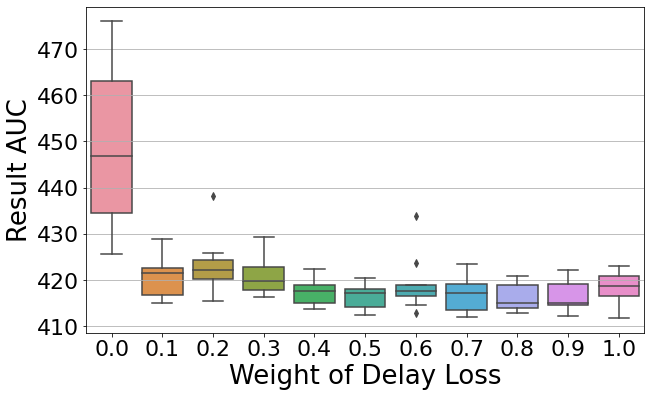

In [60]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=final_res_alpha[final_res_alpha[0.0] < 500])
plt.xticks(fontsize=22);
plt.yticks(fontsize=22);
plt.xlabel('Weight of Delay Loss', fontsize=26)
plt.ylabel('Result AUC', fontsize=26);
plt.grid(axis='y')
plt.savefig('compare_alphas.pdf', bbox_inches='tight')